In [1]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from sklearn import preprocessing
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [15]:
#df = pd.read_csv('./lung.csv') 
df = pd.read_csv('./独立实验数据.csv',encoding='gbk') 
df

,content,label
0,肝S7、S5近包膜下、肝S4及S2见多发小结节影，T1WI低信号，T2WI高信号，DWI高信...,1
1,两肺可见多发结节，部分边界欠清，较大者位于左肺下叶(im285)，直径约5mm。双肺门无明显...,1
2,右肺上叶尖段见奇静脉弓。两肺散在结节状、斑片状、 条索状密度增高影，以两肺下叶显著，边界模糊...,0
3,肝脏部分缺如，肝FSV段术区见一类圆形稍长T1、 稍长T2信号，边缘呈环状短T1短T2信号，...,0
4,肝脏形态及大小尚正常，包膜光整。反相位全肝信号无衰减。肝脏见多发结节状长T1、稍长T2信号结...,0
...,...,...
261,患者系结肠癌伴肺转移 结肠姑息术后。双肺见多发结节状高密度影，边界尚清，双肺下叶者较大，较大...,1
262,肝脏大小、形态正常，轮廓光整，肝左叶见点状钙化灶，余肝实质内未见明显异常密影。胆囊体积不大，...,1
263,"患者系直肠癌治疗后复查，两肺多发结节状、团块状实变影， 边缘呈分叶状，大者直径约3 Dam,...",0
264,肝脏形状及大小尚正常，包膜光整，肝实质内可见多发类圆形长T1、长T2信号， 信号均匀，边界清...,1


# 数据预处理

In [7]:
#将非汉字替换为""
df['content']= df['content'].str.replace("[^\u4e00-\u9fa5]", "")

#加载停止词
stopwords=pd.read_csv("./stopwords.txt",index_col=False,quoting=3,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def clean_text(text):
    wordlist = jieba.lcut(text) 
    #去除停用词和长度小于2的词语
    wordlist = [w for w in wordlist if w not in stopwords and len(w)>=2]
    #词语之间以空格间隔
    document =  " ".join(wordlist)
    return document

#使用dataframe.agg对content列实行clean_text方法
df['content'] = df.agg({'content': clean_text})
corpus = df['content']

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.754 seconds.
Prefix dict has been built successfully.


In [8]:
data_jieba=pd.DataFrame(corpus)#数据有三列，列名分别为one,two,three
#data_jieba.to_csv("data_jieba" + ".csv",sep=',')

data_jieba.to_csv("data_jieba_experiment" + ".csv",sep=',')

In [9]:
#文本向量化，转换为文档——术语矩阵
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(corpus)
doc_term_matrix

<266x1560 sparse matrix of type '<class 'numpy.int64'>'
	with 20052 stored elements in Compressed Sparse Row format>

# 计算主题困惑度

Best # of Topic:  6


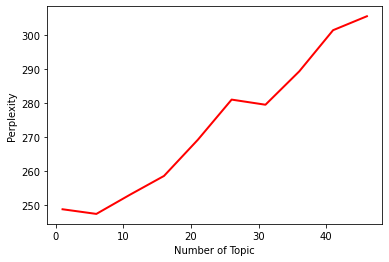

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
[248.83122439272444, 247.46234976929955, 253.14240826591603, 258.63239607116014, 269.2621177186781, 281.086022310294, 279.578278961501, 289.39838452048906, 301.5016640029416, 305.6045549372031]


In [10]:
n_topics = range(1, 50, 5)
perplexityLst = [1.0]*len(n_topics)

#训练LDA并打印训练时间
lda_models = []
for idx, n_topic in enumerate(n_topics):
    lda = LatentDirichletAllocation(n_components=n_topic,                        
                                    doc_topic_prior=1/n_topic, #default
                                    topic_word_prior=1/n_topic, #default
                                    random_state=888)
    lda.fit(doc_term_matrix)
    perplexityLst[idx] = lda.perplexity(doc_term_matrix)
    lda_models.append(lda)

#打印最佳模型
best_index = perplexityLst.index(min(perplexityLst))
best_n_topic = n_topics[best_index]
best_model = lda_models[best_index]
print ("Best # of Topic: ", best_n_topic)

#绘制不同主题数perplexity的不同
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(n_topics, perplexityLst,color="red", linewidth=2)
ax.set_xlabel("Number of Topic")
ax.set_ylabel("Perplexity")
#plt.grid(True)
#plt.savefig("Perplexity-Topics")
plt.show()
print([i for i in n_topics])
print(perplexityLst)

# LDA模型训练及结果

In [26]:
#K = 16
K = 6
lda = LatentDirichletAllocation(n_components=K,
                                doc_topic_prior=1/K,
                                topic_word_prior=1/K,
                                random_state=888)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(doc_topic_prior=0.16666666666666666, n_components=6,
                          random_state=888,
                          topic_word_prior=0.16666666666666666)

In [27]:
#输出每个主题对应词语
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

n_top_words = 20
doc_term_matrix_feature_names = vectorizer.get_feature_names()
topic_word = print_top_words(lda,doc_term_matrix_feature_names, n_top_words)

Topic #0:
回声 均匀 未见 规则 扩张 内径 分布 肝内 包膜 肝区 红色 入肝 纹理 光整 腹膜 胀气 见点 其内 胰管 胰体
Topic #1:
未见 异常 密度 强化 肿大 均匀 增厚 结石 盆腔 软组织 结节 体积 高密度 膀胱 低密度 充盈 边界 肿块 腹膜 脾脏
Topic #2:
肠周 超声 稍长 分层 病灶 内侧 显影 显示 造影剂 支稍 未见肠 渐进 回盲 黏膜 小肠 肾上腺 叶上 肠腔 组织 延迟
Topic #3:
直肠 强化 肠系膜 肠壁 增强 均匀 未见 腹膜 测量 病变 筋膜 多发 稍长 数量 可疑 密度 增厚 结节 反折 短径
Topic #4:
未见 强化 异常 均匀 增强 肿大 边界 多发 结节 密度 圆形 低密度 扩张 正常 高密度 扫描 脾脏 内见 胰腺 较大
Topic #5:
括约肌 带未见 示肝 局部凸 外周 肛管 侵至 导致 结构式 更长 稍短 持续 未见异常 改变 弥散 水平 影短径 增粗 肿块 黏液


In [28]:
#输出文档——主题分布
topics=lda.transform(doc_term_matrix)
#np.savetxt('topic_distribution.csv',topics, delimiter = ',')

new_topics=pd.concat([pd.DataFrame(topics),df['label']],axis=1,ignore_index=True)
new_topics.to_csv('topic_distribution_experiment1.csv',index=False)
np.savetxt('topic_distribution_experiment.csv',new_topics, delimiter = ',')

In [ ]:
#输出每篇文章对应主题
topic = []
for t in topics:
    topic.append(list(t).index(np.max(t)))
df['topic']=topic
#df.to_csv("data_topic.csv",index=False)

for n in range(10):
    topic= topics[n].argmax()
    print("doc: {} topic: {}".format(n, topic))

In [10]:
#输出主题——词分布
data_normalized=preprocessing.normalize(lda.components_,norm="l1",axis=1)
#np.savetxt('word_distribution.csv',data_normalized, delimiter = ',')

# LDAvis可视化

In [8]:
pic = pyLDAvis.sklearn.prepare(lda, doc_term_matrix, vectorizer,mds='mmds')
pyLDAvis.display(pic)
#pyLDAvis.save_html(pic, 'lda_vis.html')

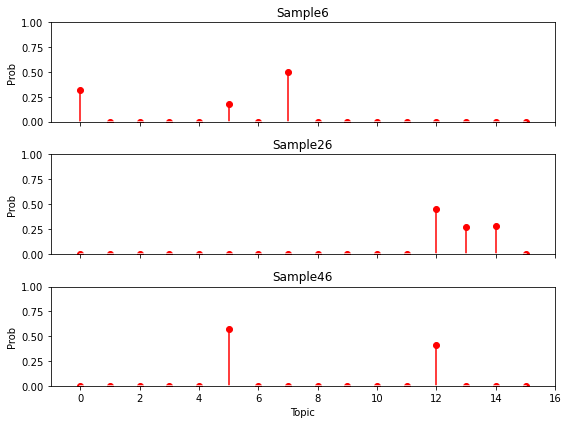

In [27]:
#主题分布可视化
f, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for i, k in enumerate([5,25,45]):
    ax[i].stem(topics[k, :], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[i].set_xlim(-1, 16)
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("Sample{}".format(k+1))

ax[2].set_xlabel("Topic")

plt.tight_layout()
#plt.savefig("5,25,45主题分布",dpi=300,bbox_inches = 'tight')
plt.show()

0 7
1 11
2 15


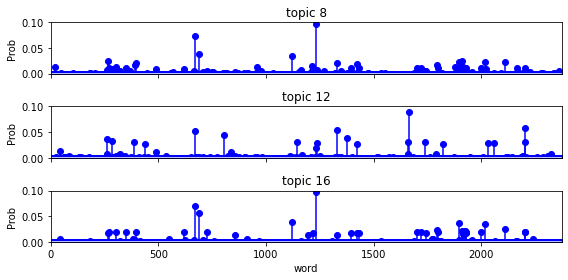

In [28]:
#主题4,14,15词分布可视化
f, ax = plt.subplots(3, 1, figsize=(8,4), sharex=True)
for i, k in enumerate([7,11,15]):
    print(i, k)
    ax[i].stem(data_normalized[k, :], linefmt='b-',
               markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(0, 2372)
    ax[i].set_ylim(0, 0.1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("topic {}".format(k+1))

ax[2].set_xlabel("word")

plt.tight_layout()
plt.savefig("8,12,16主题词分布",dpi=300,bbox_inches = 'tight')
plt.show()

0 2
1 3
2 6
3 12
4 13
5 14


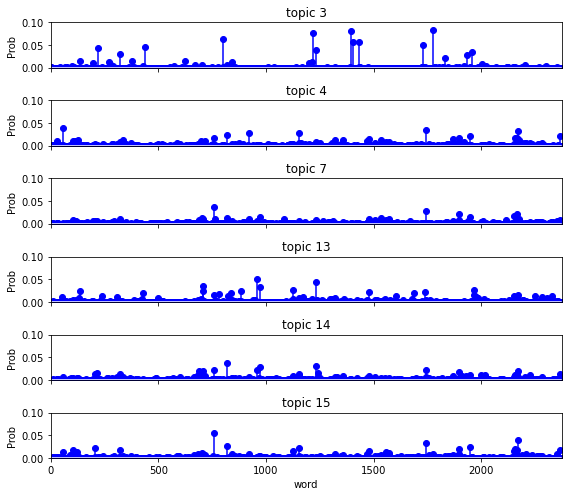

In [31]:
#主题4,14,15词分布可视化
f, ax = plt.subplots(6, 1, figsize=(8,7), sharex=True)
for i, k in enumerate([2,3,6,12,13,14]):
    print(i, k)
    ax[i].stem(data_normalized[k, :], linefmt='b-',
               markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(0, 2372)
    ax[i].set_ylim(0, 0.1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("topic {}".format(k+1))

ax[5].set_xlabel("word")

plt.tight_layout()
#plt.savefig("3,6,12,13,14主题词分布",dpi=300,bbox_inches = 'tight')
plt.show()

0 0
1 1
2 2
3 4
4 5
5 8
6 9
7 10


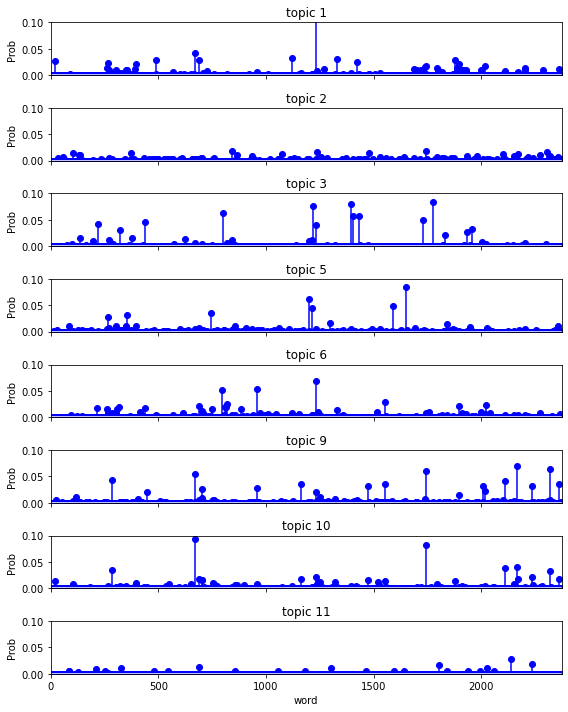

In [19]:
#主题4,14,15词分布可视化
f, ax = plt.subplots(8, 1, figsize=(8,10), sharex=True)
for i, k in enumerate([0,1,2,4,5,8,9,10]):
    print(i, k)
    ax[i].stem(data_normalized[k, :], linefmt='b-',
               markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(0, 2372)
    ax[i].set_ylim(0, 0.1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("topic {}".format(k+1))

ax[7].set_xlabel("word")

plt.tight_layout()
plt.savefig("0,1,2,4,5,8,9,10主题词分布",dpi=300,bbox_inches = 'tight')
plt.show()